In [1]:
%load_ext tensorboard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import os, cv2, json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB4
from keras.optimizers import Adam





2023-10-16 22:21:56.371399: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 22:21:57.332454: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 22:21:57.332570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 22:21:57.335123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-16 22:21:57.642547: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 22:21:57.651423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
print(os.getcwd())

/home/gayepaap/DIT/computer vision /dataset


In [4]:
WORK_DIR = os.getcwd()+'/cassava-disease'
os.listdir(WORK_DIR)

['sample_submission_file.csv',
 'random.txt',
 'test',
 'extraimages.zip',
 'train',
 'extraimages',
 'train.zip',
 'test.zip']

In [6]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train"))))

Train images: 5


In [8]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [10]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "sample_submission_file.csv"))
train_labels.head()


,Category,Id
0,cbsd,test-img-0.jpg
1,cmd,test-img-1.jpg
2,cbb,test-img-2.jpg
3,cmd,test-img-3.jpg
4,cbsd,test-img-4.jpg


In [54]:
Category=['cbb','cbsd','cgm','cmd','healtly']


0    cbsd
Name: Category, dtype: object
Impossible de lire l'image : test-img-0.jpg
Impossible de lire l'image : test-img-0.jpg
Impossible de lire l'image : test-img-0.jpg
Impossible de lire l'image : test-img-0.jpg
Impossible de lire l'image : test-img-0.jpg


[ WARN:0@3018.519] global loadsave.cpp:248 findDecoder imread_('/home/gayepaap/DIT/computer vision /dataset/cassava-disease/train/cbb/test-img-0.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3018.520] global loadsave.cpp:248 findDecoder imread_('/home/gayepaap/DIT/computer vision /dataset/cassava-disease/train/cbsd/test-img-0.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3018.520] global loadsave.cpp:248 findDecoder imread_('/home/gayepaap/DIT/computer vision /dataset/cassava-disease/train/cgm/test-img-0.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3018.522] global loadsave.cpp:248 findDecoder imread_('/home/gayepaap/DIT/computer vision /dataset/cassava-disease/train/cmd/test-img-0.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3018.522] global loadsave.cpp:248 findDecoder imread_('/home/gayepaap/DIT/computer vision /dataset/cassava-disease/train/healtly/test-img-0.jpg'): can't open/read file: check file path/integ

TypeError: Image data of dtype object cannot be converted to float

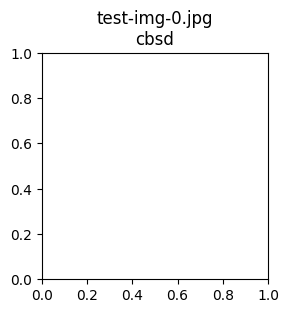

In [56]:
# Liste de noms de fichiers d'images que vous souhaitez extraire
sample_images = ['test-img-0.jpg','train-cbb-18.jpg','1000910826.jpg','1000201771.jpg','1003442061.jpg']

# Filtrer le DataFrame train_labels
sample_images_df = train_labels[train_labels['Id'].isin(sample_images)]
print(sample_images_df.Category)

# Afficher les images
plt.figure(figsize=(10, 10))
for ind, (image_id, label) in enumerate(zip(sample_images_df['Id'], sample_images_df['Category'])):
    plt.subplot(3, 2, ind + 1)
    #image = cv2.imread(os.path.join(WORK_DIR, "train", image_id))
    for cat in Category:
        image = cv2.imread(os.path.join(WORK_DIR, f"train/{cat}/", image_id))
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Le reste du code pour afficher l'image
        else:
            print(f"Impossible de lire l'image : {image_id}")

    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title('{}\n{}'.format(image_id, label))
    plt.imshow(image)
    plt.axis("off")

plt.show()


[ WARN:0@2226.069] global loadsave.cpp:248 findDecoder imread_('/home/gayepaap/DIT/computer vision /dataset/cassava-disease/train/test-img-0.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


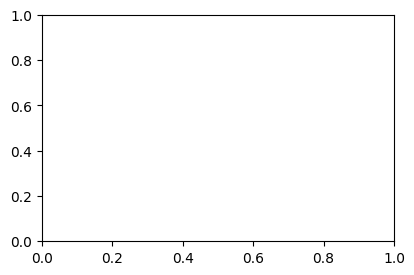

In [34]:
# Échantillon d'images provenant de 5 classes différentes
sample_images = ['test-img-0.jpg','1000723321.jpg','1000910826.jpg','1000201771.jpg','1003442061.jpg']
sample_images_df = train_labels[train_labels.Id.isin(sample_images)]
plt.figure(figsize=(10,10))
for ind, (image_id, label) in enumerate(zip(sample_images_df.Id, sample_images_df.Category)):
    plt.subplot(3, 2, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title('{}\n{}'.format(image_id,label))
    plt.imshow(image)
    plt.axis("off")

plt.show()

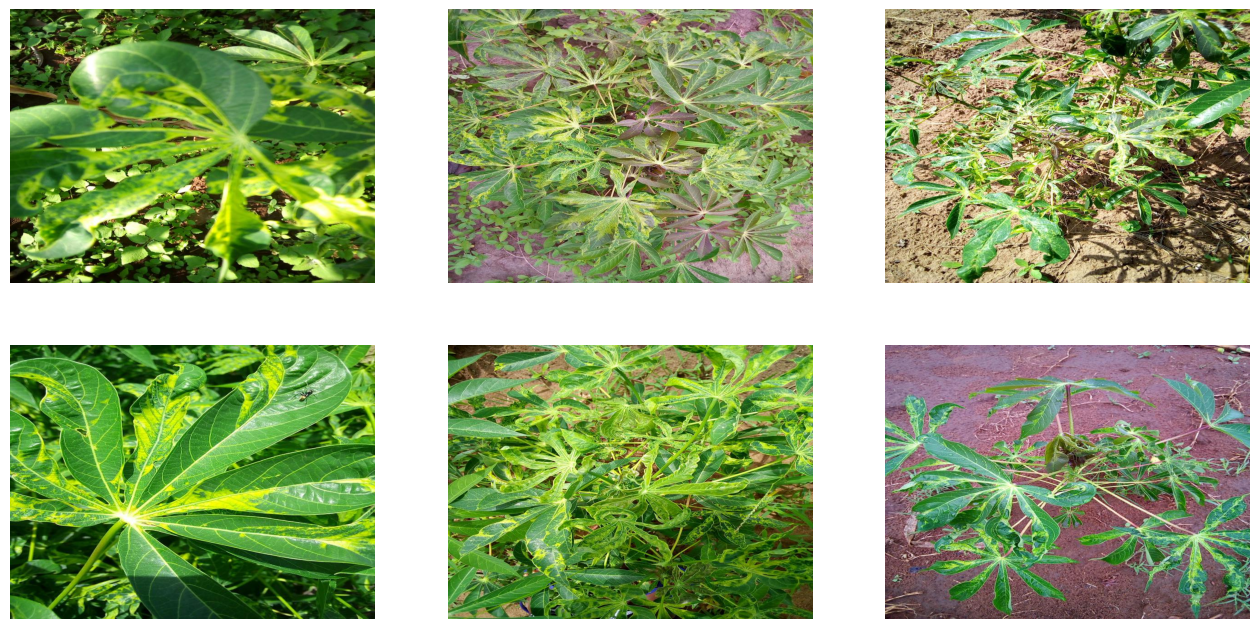

In [ ]:
#quelques photos avec la classe cmd
sample = train_labels[train_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")

plt.show()

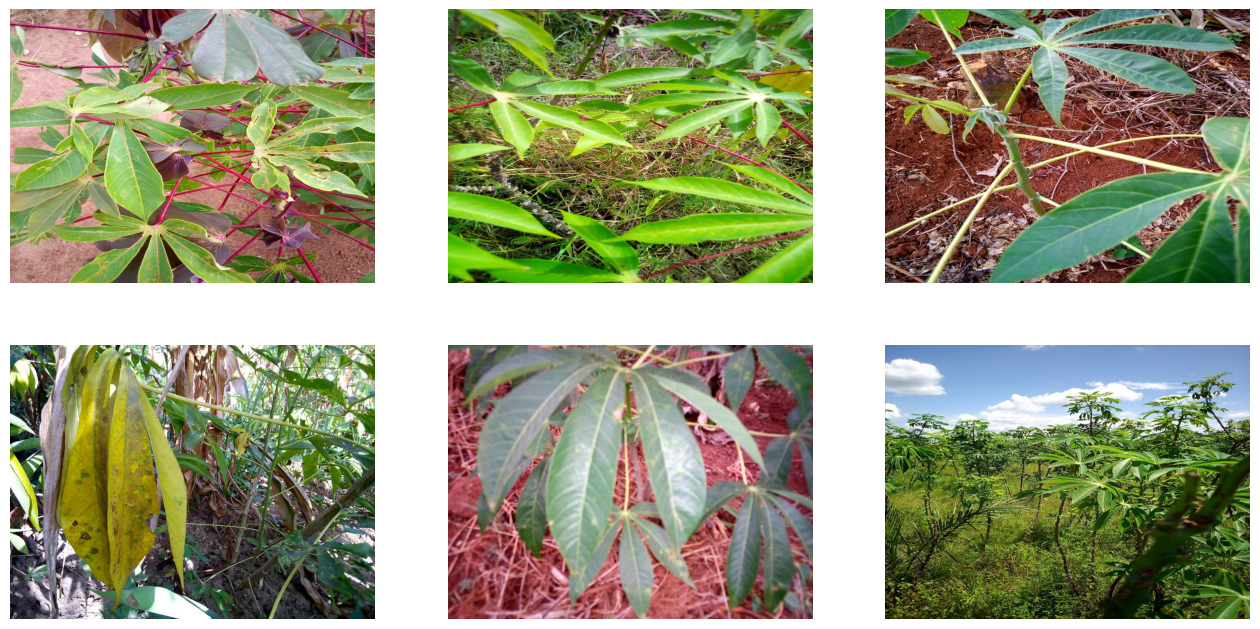

In [ ]:
#Quelques photos de plantes en bonne santé
sample = train_labels[train_labels.label == 4].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")

plt.show()

In [28]:
y_pred = [3] * len(train_labels.label)
print('The baseline accuracy: %.3f'
      %accuracy_score(y_pred, train_labels.label,normalize=True))

AttributeError: 'DataFrame' object has no attribute 'label'

In [ ]:
#Notre futur modèle doit avoir une précision supérieure à 0,615.

In [ ]:
#pré-traitement des images
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 10
TARGET_SIZE = 299

In [ ]:
train_labels.label = train_labels.label.astype('str')
#Le paramètre validation_split nous permet de diviser 20 % des données dans l'ensemble de validation automatiquement sans diviser le test de formation.
#Ensuite, vous pouvez permettre à .flow_from_dataframe de séparer le train de la validation dans les données.
train_generator = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     rotation_range = 5,
                                     fill_mode = 'constant',
                                     shear_range = 0.2,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [ ]:
class_labels = list(train_generator.class_indices.keys())# pour recuperer les label reels

# Accédez au premier batch d'images
images_batch = train_generator[0][0]
labels_batch = train_generator[0][1]

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images_batch[i])
    plt.title(f"label: {class_labels[int(labels_batch[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#Modelisation

In [ ]:
def create_model():
    model = models.Sequential()

    model.add(EfficientNetB4(include_top = False, weights = 'imagenet',
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [ ]:
model = create_model()

71686520/71686520 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 10, 10, 1792)      17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 8965      
                                                                 
Total params: 17682788 (67.45 MB)
Trainable params: 17557581 (66.98 MB)
Non-trainable params: 125207 (489.09 KB)
_________________________________________________________________
